# ATMOS 2022 - MODIS Analysis

-----------

## 0. Import Libraries

In [1]:
from utils.data import *
from utils.utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import proplot

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## 1. Creating Urban-Rural Histograms

In [27]:
provinces = ['istanbul', 'ankara']
source_type = 'terra'

# numbers starting with 2 or 3: urban
# numbers starting with 1 except 10: rural
# number 10: water
urban_tiles = [21,22,23,30]
rural_tiles = [11,12,13]
lu_year = 2015

In [ ]:
modis_data_dict = {}
# add urban and rural variables to the given province modis data
for province in provinces:
    
    # open reprojected modis and land use data
    lu_repr, modis_repr = reproject_modis_landuse_data(province, source_type)    
    
    # classify land use data to urban and rural tiles
    lu_repr_class = classify_urban_rural(lu_repr.sel(time=lu_year), urban_tiles, rural_tiles) 
    
    # K to C
    modis_repr = modis_repr - 273.15 
    
    # remove automatically created very big values (due to reprojection) and make a dataset
    modis_repr_copy = xr.where(modis_repr>500, np.nan, modis_repr).to_dataset(name='temp')
    
    # assign new variables named 'urban' and 'rural' containing the 'urban' and 'rural' tiles, respectively
    modis_repr_copy_class = modis_repr_copy.assign(urban=lambda x: xr.where(lu_repr_class==1, x.temp, np.nan))
    modis_repr_copy_class = modis_repr_copy_class.assign(rural=lambda x: xr.where(lu_repr_class==0, x.temp, np.nan))
    
    modis_data_dict[province] = modis_repr_copy_class

In [24]:
modis_data_dict['istanbul']

<xarray.Dataset>
Dimensions:      (x: 166, y: 87, time: 2899)
Coordinates:
  * x            (x) float64 2.35e+06 2.352e+06 ... 2.514e+06 2.516e+06
  * y            (y) float64 4.966e+06 4.964e+06 4.964e+06 ... 4.88e+06 4.88e+06
  * time         (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2018-12-31
    band         int64 1
    spatial_ref  int64 0
Data variables:
    temp         (time, y, x) float32 nan nan nan nan 6.27 ... nan nan nan nan
    urban        (y, x, time) float32 dask.array<chunksize=(87, 166, 2899), meta=np.ndarray>
    rural        (y, x, time) float32 dask.array<chunksize=(87, 166, 2899), meta=np.ndarray>

/home/berkaydonmez/anaconda3/envs/cirrus_env_v3/lib/python3.9/site-packages/proplot/ui.py:406: ProPlotWarning: You specified both figsize=(6, 3) and axwidth=1.5. Ignoring 'axwidth'.
/home/berkaydonmez/anaconda3/envs/cirrus_env_v3/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)
/home/berkaydonmez/anaconda3/envs/cirrus_env_v3/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they should be passed as keyword, not positionally.
  result = f

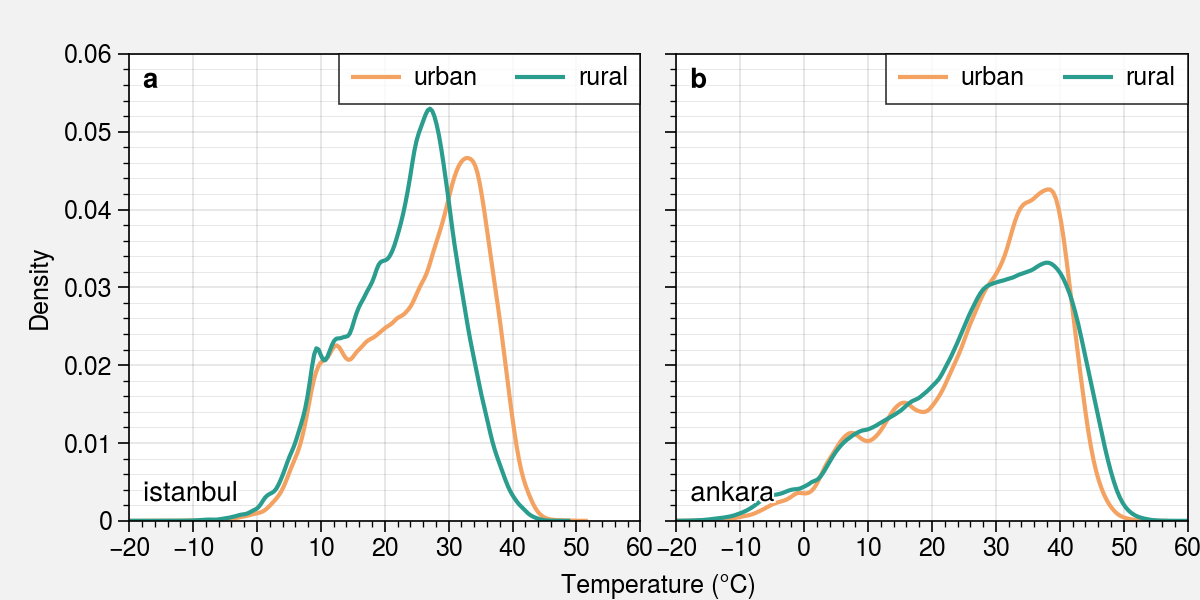

In [28]:
# start figure
f, axs = proplot.subplots(array=[[1, 2]], hratios=(1),
                          hspace=0.20, figsize=(6,3),
                          share=3, axwidth=1.5, tight=False)

# colors for lines
color_map = {'urban': '#f4a261',
             'rural': '#2a9d8f'}

# make kdeplots containing urban and rural temperature distributions
for i, province in enumerate(provinces):
    
    # flatten and make a list out of the xarray datasets before plotting
    flatten_data_urban = remove_nan_from_array(np.array(modis_data_dict[province]['urban']).flatten())
    flatten_data_rural = remove_nan_from_array(np.array(modis_data_dict[province]['rural']).flatten())
    
    sns.kdeplot(flatten_data_urban, ax=axs[i], color=color_map['urban'], label='urban', legend=True)
    sns.kdeplot(flatten_data_rural, ax=axs[i], color=color_map['rural'], label='rural', legend=True)

# format subfigures
for i in range(2):
    axs[i].format(ylabel='Density', xlabel='Temperature (°C)',
                  ygridminor=True, ygrid=True, title=provinces[i],
                  titleloc='ll', xrotation=0, xlim=(-20, 60), ylim=(0, 0.06),
                  xlocator=proplot.arange(-20, 60, 10))

# format whole figure
axs.format(abcloc='ul', abc=True,)
axs.legend()
    
# savefig    
plt.savefig(fr'pictures/modis_pdf_fig.jpeg',
            bbox_inches='tight', optimize=False,
            progressive=True, dpi=300)